<a href="https://colab.research.google.com/github/masayuki038/kaggle-regression-with-abalone-dataset/blob/main/kaggle_regression_with_abalone_dataset_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e4:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F72489%2F8096274%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240408%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240408T144847Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2adb62f2a3206dfd642219682d86a97ac49826e9eec2eed6b223a0787f344ad4ba2158397d4d7fc10a7ae604e644f1212bad8f5b7d2db3f0ae5d5ca20161849f0b191f83043bcbfeb00818cb153d157ed749e2b0c43a0cf1358786307d7865c85b937bede2f0ad449605b46ca7eed6663181659802297acf89ec0f5ab121b191e5b4afb0b1eb47c7ee7f49ff2d2033911e28129ea7a852a7f169f98caf4465e7a6bb1d0369a0ae69bdbe52f9398aa98416a8db6ca9671402693a739c9d8bf2185c686df44fa117e4aa823374c21f9181c69be173ff51cf07be090d8b4027788a0432fd13dd75d5411fab83614954f92b046a7d44d10891a1cdd8cab7fb8e4f26'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2529839 bytes downloaded
Downloaded and uncompressed: playground-series-s4e4
Data source import complete.


# Abalone age estimation: EDA which makes sense

This model analyzes the competition data and compares the performance of a few models with tuned hyperparameters. It furthermore shows how to ensemble the models.

Reference: [Regression with an Abalone Dataset](https://www.kaggle.com/competitions/playground-series-s4e4)

In [11]:
!pip install --quiet colorama catboost

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Style
import xgboost
import lightgbm
import catboost

from sklearn.base import clone
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, SplineTransformer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error

In [13]:
# Configuration
COMPUTE_TEST_PRED = True
USE_ORIGINAL_DATA = True

# Containers for results
oof, test_pred = {}, {}

# Reading the data

We read the data files and observe the following:
- The sex of these animals is either male, female or infant. All other features are numeric.
- All feature values end in 0 or 5 - this is typical for measurements with finite precision.
- The target variable, Rings, is integer.

**Insight:**
- As the target variable is integer, we can use it to cross-validate with a `StratifiedKFold`. The stratification gives a better cv–lb correlation than a simple `KFold`.
- With >90000 samples, the training dataset is too big for kernel-based regressors (e.g., `SVR`, `KernelRidge`, `GaussianProcessRegressor`).
- `Sex` is a categorical feature. For some models, we'll need to one-hot encode it, for other models it suffices to mark it as categorical.

In [14]:
def add_features(df):
  df['Height_Shell_weight'] = df['Height'] * df['Shell weight']
  return df

In [15]:
train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv', index_col='id')

train['Sex'] = train.Sex.astype('category')
test['Sex'] = test.Sex.astype(train.Sex.dtype)

if not train.isna().any().any():
    print('There are no missing values in train.')
if not test.isna().any().any():
    print('There are no missing values in test.')

print(f"Train shape: {train.shape}   test shape: {test.shape}")

train = add_features(train)
test = add_features(test)

numeric_features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Height_Shell_weight']
numeric_vars = numeric_features + ['Rings']

train

There are no missing values in train.
There are no missing values in test.
Train shape: (90615, 9)   test shape: (60411, 8)


,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Height_Shell_weight
id,,,,,,,,,,
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,0.036000
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,0.046400
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,0.000125
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,0.037500
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,0.025675
...,...,...,...,...,...,...,...,...,...,...
90610,M,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6,0.003375
90611,M,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9,0.036000
90612,I,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6,0.007743


We can add the original dataset to the synthetic data for training. Although with only 4177 samples it is twenty times smaller than the competition dataset, its addition improves the scores of all models.

Thanks to @iqbalsyahakbar [for the code](https://www.kaggle.com/competitions/playground-series-s4e4/discussion/488082).

In [16]:
if USE_ORIGINAL_DATA:
    !pip install ucimlrepo

    from ucimlrepo import fetch_ucirepo

    # fetch dataset
    abalone = fetch_ucirepo(id=1)

    # data (as pandas dataframes)
    original_dataset = pd.concat([abalone.data.features, abalone.data.targets], axis = 1).rename({
        'Whole_weight' : 'Whole weight',
        'Shucked_weight' : 'Whole weight.1',
        'Viscera_weight' : 'Whole weight.2',
        'Shell_weight' : 'Shell weight'
    }, axis = 1)
    original_dataset = add_features(original_dataset)
    original_dataset['Sex'] = original_dataset.Sex.astype(train.Sex.dtype)
    print("Original dataset shape:", original_dataset.shape)

Original dataset shape: (4177, 10)


# Correlation

All features are highly correlated to the target variable. This is very plausible: The older an individual abalone gets, the higher its weight, length, and so on.

**Insight:**
- There is no need to downselect features. All features are useful for predicting the target.
- We don't need to look at feature importances. All features are important.

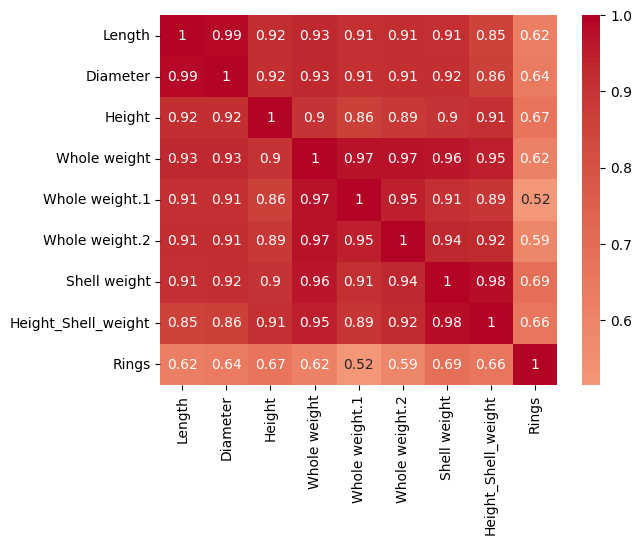

In [17]:
cc = np.corrcoef(train[numeric_vars], rowvar=False)
sns.heatmap(cc, center=0, cmap='coolwarm', annot=True,
            xticklabels=numeric_vars, yticklabels=numeric_vars)
plt.show()

# Target distribution

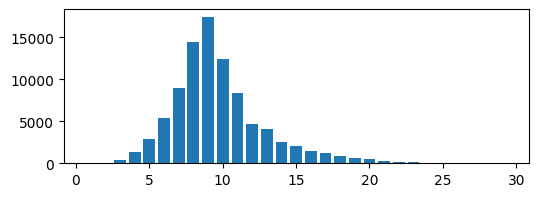

In [18]:
vc = train.Rings.value_counts()
plt.figure(figsize=(6, 2))
plt.bar(vc.index, vc)
plt.show()

**Insight:**
- Because all training targets are between 1 and 29, we may clip all predictions to the interval \[1, 29\].

# Feature engineering

Because the competition metric is RMSLE, all our models will predict the logarithm of the target. In this situation, some models will perform better if we feed them the logarithm of the features.

In [19]:
log_features = []
for col in numeric_features:
    train[f'log_{col}'] = np.log1p(train[col])
    test[f'log_{col}'] = np.log1p(test[col])
    if USE_ORIGINAL_DATA:
        original_dataset[f'log_{col}'] = np.log1p(original_dataset[col])
    log_features.append(f'log_{col}')


# Cross-validation

To ensure that our cross-validation results are consistent, we'll use the same function for cross-validating all models.

Notice that in cross-validation, we first split the dataset and then add the original data only to the training dataset. The validation dataset consists purely of competition data. This setup lets us correctly assess whether the original data are useful or harmful.

In [20]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

def cross_validate(model, label, features=test.columns, n_repeats=1):
    """Compute out-of-fold and test predictions for a given model.

    Out-of-fold and test predictions are stored in the global variables
    oof and test_pred, respectively.

    If n_repeats > 1, the model is trained several times with different seeds.

    All predictions are clipped to the interval [1, 29].
    """
    scores = []
    oof_preds = np.full_like(train.Rings, np.nan, dtype=float)
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train, train.Rings)):
        X_tr = train.iloc[idx_tr][features]
        X_va = train.iloc[idx_va][features]
        y_tr = train.iloc[idx_tr].Rings
        y_va = train.iloc[idx_va].Rings

        if USE_ORIGINAL_DATA:
            X_tr = pd.concat([X_tr, original_dataset[features]], axis=0)
            y_tr = pd.concat([y_tr, original_dataset.Rings], axis=0)

        y_pred = np.zeros_like(y_va, dtype=float)
        for i in range(n_repeats):
            m = clone(model)
            if n_repeats > 1:
                mm = m
                if isinstance(mm, Pipeline):
                    mm = mm[-1]
                if isinstance(mm, TransformedTargetRegressor):
                    mm = mm.regressor
                mm.set_params(random_state=i)
            m.fit(X_tr, y_tr)
            y_pred += m.predict(X_va)
        y_pred /= n_repeats
        y_pred = y_pred.clip(1, 29)

#         residuals = np.log1p(y_va) - np.log1p(y_pred)
#         plt.figure(figsize=(6, 2))
#         plt.scatter(y_pred, residuals, s=1)
#         plt.axhline(0, color='k')
#         plt.show()

        score = mean_squared_log_error(y_va, y_pred, squared=False)
        print(f"# Fold {fold}: RMSLE={score:.5f}")
        scores.append(score)
        oof_preds[idx_va] = y_pred
    print(f"{Fore.GREEN}# Overall: {np.array(scores).mean():.5f} {label}{Style.RESET_ALL}")
    oof[label] = oof_preds

    if COMPUTE_TEST_PRED:
        # Retrain n_repeats times with the whole dataset and average
        y_pred = np.zeros(len(test), dtype=float)
        X_tr = train[features]
        y_tr = train.Rings
        if USE_ORIGINAL_DATA:
            X_tr = pd.concat([X_tr, original_dataset[features]], axis=0)
            y_tr = pd.concat([y_tr, original_dataset.Rings], axis=0)
        for i in range(n_repeats):
            m = clone(model)
            if n_repeats > 1:
                mm = m
                if isinstance(mm, Pipeline):
                    mm = mm[-1]
                if isinstance(mm, TransformedTargetRegressor):
                    mm = mm.regressor
                mm.set_params(random_state=i)
            m.fit(X_tr, y_tr)
            y_pred += m.predict(test[features])
        y_pred /= n_repeats
        y_pred = y_pred.clip(1, 29)
        test_pred[label] = y_pred


# Models

We compare several models. As the competition requires us to optimize the mean squared log error, we use a `TransformedTargetRegressor`. If a raw model optimizes the mean squared error (MSE), its `TransformedTargetRegressor` will optimize the mean squared log error.

We start with two linear models (ridge regression). For these models, we need to one-hot encode the categorical feature and to scale all features. The linear models improve if we add some nonlinear features with either `PolynomialFeatures` or `Nystroem`.

In [21]:
# PolynomialFeatures + Ridge
model = make_pipeline(ColumnTransformer([('ohe', OneHotEncoder(drop='first'), ['Sex'])],
                                        remainder='passthrough'),
                      StandardScaler(),
                      PolynomialFeatures(degree=3),
                      TransformedTargetRegressor(Ridge(100),
                                                 func=np.log1p,
                                                 inverse_func=np.expm1))
cross_validate(model, 'Poly-Ridge', numeric_features + log_features + ['Sex'])
# Overall: 0.15293 Poly-Ridge

# Fold 0: RMSLE=0.15145
# Fold 1: RMSLE=0.15334
# Fold 2: RMSLE=0.15323
# Fold 3: RMSLE=0.15324
# Fold 4: RMSLE=0.15291
# Overall: 0.15283 Poly-Ridge


In [22]:
# Nystroem transformer + Ridge
model = make_pipeline(ColumnTransformer([('ohe', OneHotEncoder(drop='first'), ['Sex'])],
                                        remainder='passthrough'),
                      StandardScaler(),
                      Nystroem(n_components=500),
                      TransformedTargetRegressor(Ridge(0.1),
                                                 func=np.log1p,
                                                 inverse_func=np.expm1))
cross_validate(model, 'Nystroem-Ridge', numeric_features + log_features + ['Sex'])
# Overall: 0.15159 Nystroem-Ridge

# Fold 0: RMSLE=0.14974
# Fold 1: RMSLE=0.15169
# Fold 2: RMSLE=0.15221
# Fold 3: RMSLE=0.15219
# Fold 4: RMSLE=0.15189
# Overall: 0.15154 Nystroem-Ridge


`KNeighborsRegressor` seems to be the worst of all models I looked at for this competition:

In [23]:
# K nearest neighbors
model = make_pipeline(ColumnTransformer([('ohe', OneHotEncoder(drop='first'), ['Sex'])],
                                        remainder='passthrough'),
                      StandardScaler(),
                      TransformedTargetRegressor(KNeighborsRegressor(n_neighbors=50),
                                                 func=np.log1p,
                                                 inverse_func=np.expm1))
cross_validate(model, 'KNN', log_features + ['Sex'])
# Overall: 0.15458 KNN


# Fold 0: RMSLE=0.15249
# Fold 1: RMSLE=0.15515
# Fold 2: RMSLE=0.15524
# Fold 3: RMSLE=0.15453
# Fold 4: RMSLE=0.15485
# Overall: 0.15445 KNN


In [24]:
# Random forest
model = make_pipeline(ColumnTransformer([('ohe', OneHotEncoder(drop='first'), ['Sex'])],
                                        remainder='passthrough'),
                      TransformedTargetRegressor(RandomForestRegressor(n_estimators=200, min_samples_leaf=8, max_features=5),
                                                 func=np.log1p,
                                                 inverse_func=np.expm1))
cross_validate(model, 'Random forest', log_features + ['Sex'])
# Overall: 0.14962 Random forest

# Fold 0: RMSLE=0.14804
# Fold 1: RMSLE=0.14971
# Fold 2: RMSLE=0.15044
# Fold 3: RMSLE=0.15013
# Fold 4: RMSLE=0.15022
# Overall: 0.14971 Random forest


In [25]:
# ExtraTreesRegressor
model = make_pipeline(ColumnTransformer([('ohe', OneHotEncoder(drop='first'), ['Sex'])],
                                        remainder='passthrough'),
                      TransformedTargetRegressor(ExtraTreesRegressor(n_estimators=200, min_samples_leaf=7),
                                                 func=np.log1p,
                                                 inverse_func=np.expm1))
cross_validate(model, 'ExtraTrees', log_features + ['Sex'])
# Overall: 0.15048 ExtraTrees

# Fold 0: RMSLE=0.14875
# Fold 1: RMSLE=0.15099
# Fold 2: RMSLE=0.15115
# Fold 3: RMSLE=0.15088
# Fold 4: RMSLE=0.15104
# Overall: 0.15056 ExtraTrees


In [26]:
# HistGradientBoostingRegressor
# Hyperparameters were tuned with Optuna
hgb_params = {'max_iter': 300, 'max_leaf_nodes': 43, 'early_stopping': False, 'learning_rate': 0.08019987638525192, 'min_samples_leaf': 37} # 0.14916
model = make_pipeline(ColumnTransformer([('ohe', OneHotEncoder(), ['Sex'])],
                                        remainder='passthrough'),
                      TransformedTargetRegressor(HistGradientBoostingRegressor(**hgb_params),
                                                 func=np.log1p,
                                                 inverse_func=np.expm1))
cross_validate(model, 'HGB', numeric_features + ['Sex'])
# Overall: 0.14925 HGB

# Fold 0: RMSLE=0.14741
# Fold 1: RMSLE=0.14906
# Fold 2: RMSLE=0.15008
# Fold 3: RMSLE=0.14969
# Fold 4: RMSLE=0.14935
# Overall: 0.14912 HGB


We implement two XGBoost models as suggested in @siukeitin's discussion [log1p-transformed target + MSE objective vs MSLE objective](https://www.kaggle.com/competitions/playground-series-s4e4/discussion/488283).
- The first XGBoost model optimizes MSE and has a log-transformed target.
- The second XGBoost model optimizes MSLE directly and doesn't need a target transformation.

In [27]:
# XGBoost with RMSE objective
# Hyperparameters were tuned with Optuna
xgb_params = {'grow_policy': 'lossguide', 'n_estimators': 300, 'learning_rate': 0.09471805900675286, 'max_depth': 8, 'reg_lambda': 33.33929116223339, 'min_child_weight': 27.048028004026204, 'colsample_bytree': 0.6105442825961575, 'objective': 'reg:squarederror', 'tree_method': 'hist', 'gamma': 0, 'enable_categorical': True} # 0.14859
model = TransformedTargetRegressor(xgboost.XGBRegressor(**xgb_params),
                                                 func=np.log1p,
                                                 inverse_func=np.expm1)
cross_validate(model, 'XGBoost', numeric_features + ['Sex'], n_repeats=5)
# Overall: 0.14853 XGBoost

# Fold 0: RMSLE=0.14649
# Fold 1: RMSLE=0.14860
# Fold 2: RMSLE=0.14931
# Fold 3: RMSLE=0.14914
# Fold 4: RMSLE=0.14880
# Overall: 0.14847 XGBoost


In [28]:
# XGBoost with RMSLE objective
# Hyperparameters were tuned with Optuna
xgb_params = {'grow_policy': 'depthwise', 'n_estimators': 500, 'learning_rate': 0.0896765799823656, 'max_depth': 8, 'reg_lambda': 1.003764844090402, 'min_child_weight': 0.20627702562667777, 'colsample_bytree': 0.5142803343048419, 'objective': 'reg:squaredlogerror', 'tree_method': 'hist', 'gamma': 0, 'enable_categorical': True} # 0.14875
model = xgboost.XGBRegressor(**xgb_params)
cross_validate(model, 'XGBoost-RMSLE', numeric_features + ['Sex'], n_repeats=5)


# Fold 0: RMSLE=0.14699
# Fold 1: RMSLE=0.14885
# Fold 2: RMSLE=0.14960
# Fold 3: RMSLE=0.14935
# Fold 4: RMSLE=0.14902
# Overall: 0.14876 XGBoost-RMSLE


In [29]:
# LightGBM
# Hyperparameters were tuned with Optuna
lgbm_params = {'n_estimators': 1000, 'learning_rate': 0.038622511348472645, 'colsample_bytree': 0.5757189042456357, 'reg_lambda': 0.09664116733307193, 'min_child_samples': 87, 'num_leaves': 43, 'verbose': -1} # 0.14804
model = TransformedTargetRegressor(lightgbm.LGBMRegressor(**lgbm_params),
                                                 func=np.log1p,
                                                 inverse_func=np.expm1)
cross_validate(model, 'LightGBM', numeric_features + ['Sex'], n_repeats=5)
# Overall: 0.14804 LightGBM


# Fold 0: RMSLE=0.14593
# Fold 1: RMSLE=0.14819
# Fold 2: RMSLE=0.14887
# Fold 3: RMSLE=0.14834
# Fold 4: RMSLE=0.14840
# Overall: 0.14795 LightGBM


There [was a discussion](https://www.kaggle.com/competitions/playground-series-s4e4/discussion/491703) about whether a sqrt transformation of the target was better than the log transformation. The following LightGBM model uses the sqrt transformation and has a higher error than the model above. Log transformation is the way to go!

In [30]:
# LightGBM with sqrt transformation
# Hyperparameters were tuned with Optuna
lgbm_params = {'n_estimators': 1000, 'learning_rate': 0.038622511348472645, 'colsample_bytree': 0.5757189042456357, 'reg_lambda': 0.09664116733307193, 'min_child_samples': 87, 'num_leaves': 43, 'verbose': -1} # 0.14804
model = TransformedTargetRegressor(lightgbm.LGBMRegressor(**lgbm_params),
                                                 func=np.sqrt,
                                                 inverse_func=np.square)
cross_validate(model, 'LightGBM-sqrt', numeric_features + ['Sex'], n_repeats=5)


# Fold 0: RMSLE=0.14604
# Fold 1: RMSLE=0.14823
# Fold 2: RMSLE=0.14899
# Fold 3: RMSLE=0.14848
# Fold 4: RMSLE=0.14859
# Overall: 0.14807 LightGBM-sqrt


In [31]:
# Catboost
# Hyperparameters were tuned with Optuna
cb_params = {'grow_policy': 'SymmetricTree', 'n_estimators': 1000, 'learning_rate': 0.128912681527133, 'l2_leaf_reg': 1.836927907521674, 'max_depth': 6, 'colsample_bylevel': 0.6775373040510968, 'random_strength': 0, 'boost_from_average': True, 'loss_function': 'RMSE', 'cat_features': ['Sex'], 'verbose': False} # 0.14847
model = TransformedTargetRegressor(catboost.CatBoostRegressor(**cb_params),
                                                 func=np.log1p,
                                                 inverse_func=np.expm1)
cross_validate(model, 'Catboost', log_features + ['Sex'], n_repeats=5)
# Overall: 0.14851 Catboost

# Fold 0: RMSLE=0.14641
# Fold 1: RMSLE=0.14842
# Fold 2: RMSLE=0.14908
# Fold 3: RMSLE=0.14903
# Fold 4: RMSLE=0.14876
# Overall: 0.14834 Catboost


# Ensemble

`Ridge` is always a good method to ensemble regression models. It determines the optimal weights for blending the ensemble members, as shown in the pie chart.

Note that I haven't tuned the regularization `alpha` of the regressor. If you modify the code so that you can cross-validate the ensemble and tune the hyperparameter, you'll get a better ensemble score.

Ensemble weights
Poly-Ridge        0.000000
Nystroem-Ridge    0.007012
KNN               0.000000
Random forest     0.044242
ExtraTrees        0.000000
HGB               0.046104
XGBoost           0.100480
XGBoost-RMSLE     0.063032
LightGBM          0.253711
LightGBM-sqrt     0.273538
Catboost          0.221436
dtype: float64
Total weight: 1.0095551092494839
Intercept: -0.023592054879564728
Score: 0.14779


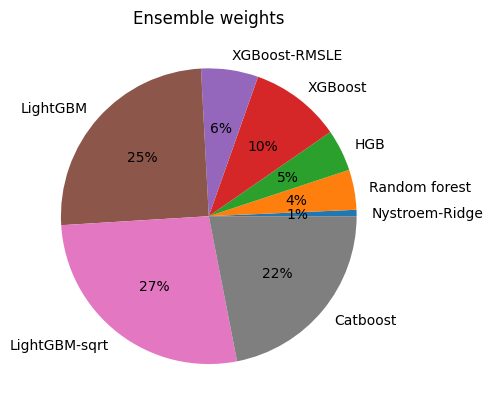

In [32]:
members = [name for name in oof.keys() if 'Stack' not in name]

X = np.log1p(np.column_stack([oof[name] for name in members]))
model = TransformedTargetRegressor(Ridge(positive=True, tol=1e-6),
                                   func=np.log1p,
                                   inverse_func=np.expm1)
model.fit(X, train.Rings)
print('Ensemble weights')
weights = pd.Series(model.regressor_.coef_, index=members)
print(weights)
print('Total weight:', weights.sum())
print('Intercept:', model.regressor_.intercept_)
oof['Stack'] = model.predict(X) # not really out-of-fold...
print(f"Score: {mean_squared_log_error(train.Rings, oof['Stack'], squared=False):.5f}")

# Pie chart
weights = weights[weights >= 0.005] # hide small weights in pie chart
plt.pie(weights, labels=weights.index, autopct="%.0f%%")
plt.title('Ensemble weights')
plt.show()

# Test predictions
if COMPUTE_TEST_PRED:
    X = np.log1p(np.column_stack([test_pred[name] for name in members]))
    test_pred['Stack'] = model.predict(X)

# Evaluation

The bar chart shows that for the given dataset, LightGBM, Catboost and XGBoost give the best predictions. The ensemble ('Stack') outperforms every single model.

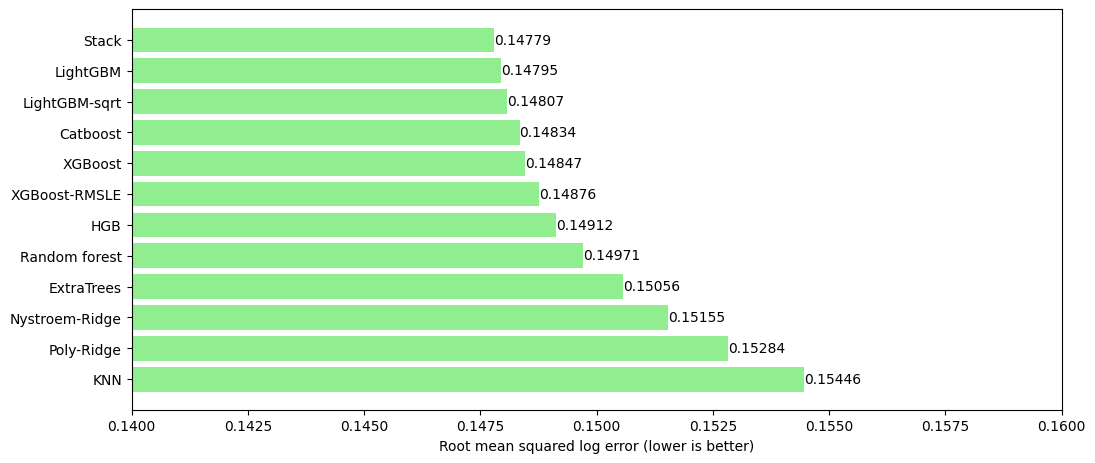

In [33]:
result_list = []
for label in oof.keys():
    score = mean_squared_log_error(train.Rings, oof[label], squared=False)
    result_list.append((label, score))
result_df = pd.DataFrame(result_list, columns=['label', 'score'])
result_df.sort_values('score', inplace=True)

plt.figure(figsize=(12, len(result_df) * 0.4 + 0.4))
bars = plt.barh(np.arange(len(result_df)), result_df.score, color='lightgreen')
plt.gca().bar_label(bars, fmt='%.5f')
plt.yticks(np.arange(len(result_df)), result_df.label)
plt.gca().invert_yaxis()
plt.xlim(0.14, 0.16)
plt.xlabel('Root mean squared log error (lower is better)')
plt.show()

# Submission

In [34]:
if COMPUTE_TEST_PRED:
    sub = pd.Series(test_pred['Stack'], index=test.index, name='Rings')
    sub.to_csv('submission.csv')
    !head submission.csv

id,Rings
90615,9.656204767612557
90616,9.734506995373556
90617,10.009260527410492
90618,10.640355404101305
90619,7.571665265702446
90620,9.271795282138736
90621,10.941843526997253
90622,6.087333733564325
90623,7.914933203059157


# Exercises

By completing at least one of the following exercises, you have a good chance of improving your leaderboard score:
1. Re-run the whole notebook with another seed for the StratifiedKFold to test for overfitting. How much do the cv scores and the ensemble weights depend on the seed?
1. Improve the ensemble by tuning the regularization and by manually excluding models.
1. Implement and tune a LightGBM model with RMSLE objective (and without target transformation) as described in @siukeitin's discussion [log1p-transformed target + MSE objective vs MSLE objective](https://www.kaggle.com/competitions/playground-series-s4e4/discussion/488283). Add it to the ensemble.
1. Implement and tune a neural network and add it to the ensemble.